# Visualize Results

## Load imports & data

In [1]:
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
# gui
import qgrid
import seaborn as sns
# pyro & pytorch
import torch
from ipywidgets import fixed, interact
from tqdm import tqdm
from scipy.io import loadmat

%matplotlib inline
qgrid.enable()

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cpu")
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
#torch.cuda.is_available()

In [3]:
from cosmos.utils.utils import (view_aoi,
                   view_aoi_class_average, view_aoi_class_summary, view_probs, view_theta,
                   view_aoi_summary, view_glimpse, write_summary, view_feature_summary, view_junk_summary)

In [4]:
from cosmos.utils.feature_read import ReadFeatures
from cosmos.utils.aoi_reader import ReadAoi
from cosmos.utils.junk_read import ReadJunks

In [67]:
#dataset = "LarryCy3sigma54"
#dataset = "Gracecy3"
#dataset = "Irenecy5"
dataset = "DanPol2"
#data = ReadAoi("Irenecy5", device)
data = ReadAoi(dataset, device)

reading config.ini for DanPol2 ... done
reading header ... done
reading drift file ... calculating cumulative drift ... done
reading aoiinfo file ... adjusting target position from frame 15.0 to frame 1 ... done
saving drift_df.csv and aoi_df.csv files ..., done
aois were read from data.pt, target.csv, and drift.csv files


In [12]:
pyro.clear_param_store()
pyro.get_param_store().load(os.path.join(data.path, "runs", dataset,"feat", "params"))

for attr in pyro.get_param_store().keys():
    setattr(data, attr, pyro.param(attr).detach().squeeze().to(device))

In [41]:
pyro.clear_param_store()
pyro.get_param_store().load(os.path.join(data.path, "runs", dataset,"junk/M2", "params"))
for attr in pyro.get_param_store().keys():
    #setattr(data, attr, pyro.param(attr).detach().squeeze().to(device))
    setattr(data, attr, pyro.param(attr).detach().to(device))

In [87]:
pyro.clear_param_store()
pyro.get_param_store().load(os.path.join(data.path, "runs", dataset, "tracker/v6/M2", "params"))

for attr in pyro.get_param_store().keys():
    setattr(data, attr, pyro.param(attr).detach().to(device))

#pyro.get_param_store().load(os.path.join(data.path, "runs/classifier/v3/K2", "params"))
#data.z_probs = pyro.param("z_probs").detach().squeeze()

# Visualize Data

## View glimpse images

In [24]:
interact(view_glimpse, frame=data.drift.index, aoi=data.target.index,
         aoi_df=fixed(data.target), drift_df=fixed(data.drift), 
         header=fixed(data.header), path_glimpse=fixed(data.path),
         selected_aoi=True, all_aois=True, label=False, offset=False)

interactive(children=(Dropdown(description='frame', options=(170, 171, 172, 173, 174, 175, 176, 177, 178, 179,…

<function cosmos.utils.utils.view_glimpse(frame, aoi, aoi_df, drift_df, header, path_glimpse, selected_aoi, all_aois, label, offset)>

In [26]:
height = int(data.header["height"])
width = int(data.header["width"])

frame = 180
glimpse_number = data.header["filenumber"][int(frame-1)]
with open(os.path.join(data.path, "{}.glimpse".format(glimpse_number))) as fid:
    fid.seek(data.header['offset'][int(frame-1)])
    img = np.fromfile(fid, dtype='>i2', count=height*width).reshape(height,width)
    img += 2**15
    img.astype(np.uint16)

## View AoI

In [15]:
# grace aoi 180

In [47]:
#aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

#interact(view_aoi_summary, aoi=aoi_widget, data=fixed(data), show_class=True)

In [82]:
data.l_probs = np.zeros(data.z_probs.shape)

In [83]:
spot_picker = binary["Intervals"]["CumulativeIntervalArray"][0,0]
for sp in spot_picker:
    aoi = int(sp[-1] - 1)
    start = int(sp[1] - 1)
    end = int(sp[2])
    if sp[0] in [-2., 0., 2.]:
        data.l_probs[aoi,start:end,0] = 1
        data.l_probs[aoi,start:end,1] = 0
    elif sp[0] in [-3., 1., 3.]:
        data.l_probs[aoi,start:end,0] = 0
        data.l_probs[aoi,start:end,1] = 1

In [ ]:
# aoi 71 78 98 141 150 165 177 180 192

In [88]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)])
frame_widget2 = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)], value=len(data.drift.index)-1)

interact(view_probs, aoi=aoi_widget, data=fixed(data), f1=frame_widget, f2=frame_widget2,
        binder=True, junk=True, sp=True)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function cosmos.utils.utils.view_probs(aoi, data, f1, f2, binder, junk, sp)>

In [74]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)])
frame_widget2 = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)], value=len(data.drift.index)-1)

interact(view_theta, aoi=aoi_widget, data=fixed(data), f1=frame_widget, f2=frame_widget2,
        theta1=False, theta2=False, m=True)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function cosmos.utils.utils.view_theta(aoi, data, f1, f2, theta1, theta2, m)>

In [86]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)])
frame_widget2 = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)], value=len(data.drift.index)-1)

interact(view_junk_summary, aoi=aoi_widget, data=fixed(data), f1=frame_widget, f2=frame_widget2,
        m1=True, m2=True, m=True)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function cosmos.utils.utils.view_junk_summary(aoi, data, f1, f2, m1, m2, m)>

In [10]:
# irene
# aoi 92 8 29

# orange
# aoi 22
# aoi 51
# aoi 81
# aoi 221

# dan-pol2 aoi 96 frame 364 430
# aoi 78 frame 500 515
# aoi 180 frame 500
# aoi 71 78 98 141 150 165 177 180 192

In [9]:
# aoi 99 frame 500 (--+)
# aoi 164 frame 625 (+++) 645 (+++) 665 (+++)
# aoi 180 frame 440 (--+) 665 (--+)
# aoi 194 frame 480 (-++) 680 (--+) 
# aoi 211 frame 430 (-++) 575 (+++) 595 (+++)
# aoi 230 frame 430 (+++) 620 (+++)
# aoi 307 frame 260 wrong 260,261,262
# aoi 324
# grace aoi 1, 90, 99, 158, 180, 211, 230

In [ ]:
# larry sigma54
# aoi 53 frame 2541

In [66]:
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)])

aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_aoi, aoi=aoi_widget, frame=frame_widget, data=fixed(data), target=True, binder=True, junk=True)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function cosmos.utils.utils.view_aoi(aoi, frame, data, target, binder, junk)>

In [23]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)])
frame_widget2 = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)], value=len(data.drift.index)-1)

interact(view_probs, aoi=aoi_widget, data=fixed(data), f1=frame_widget, f2=frame_widget2,
        binder=True, junk=True)

interactive(children=(Dropdown(description='aoi', options=((2, 0), (4, 1), (8, 2), (10, 3), (11, 4), (14, 5), …

<function cosmos.utils.utils.view_probs(aoi, data, f1, f2, binder, junk)>

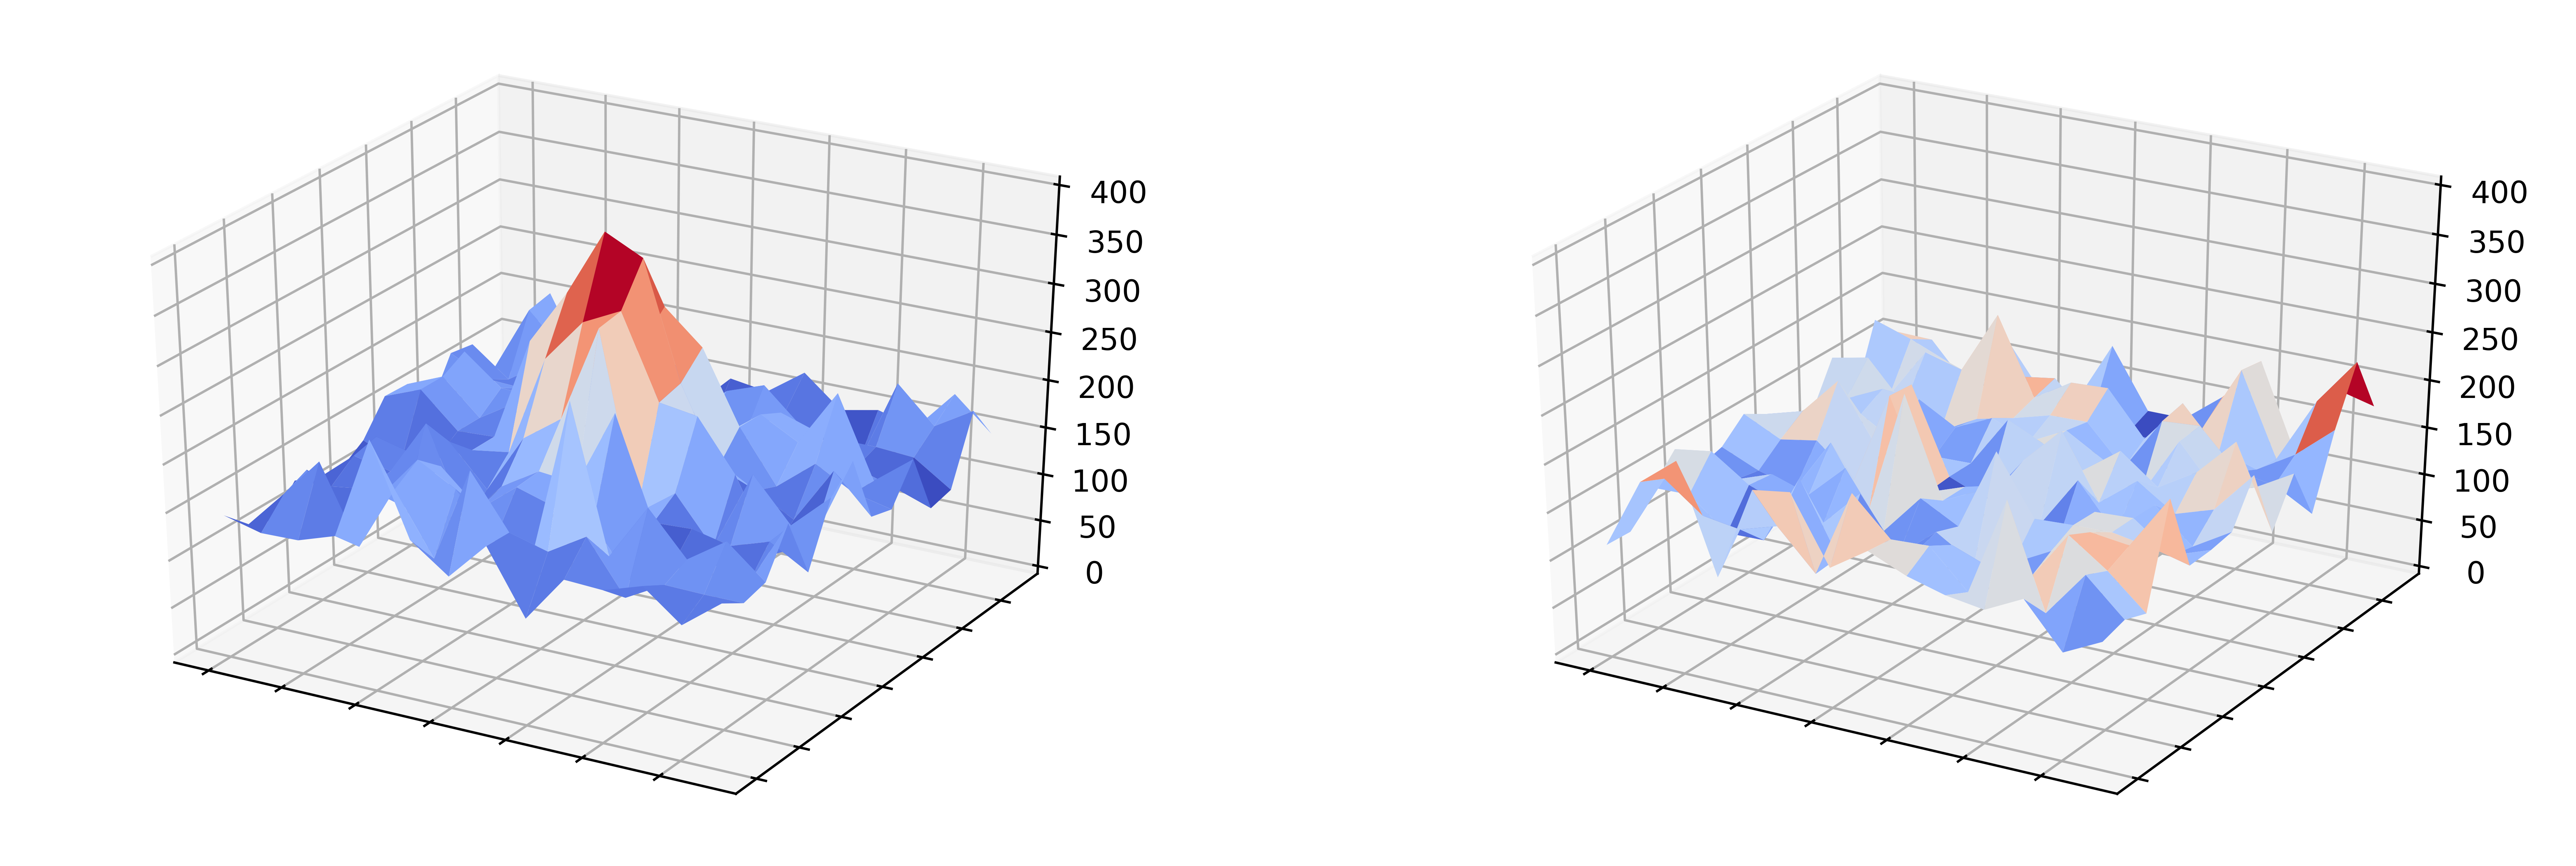

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def surface_plot (matrix, ax, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    
    
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return surf

def wireframe_plot (matrix, ax, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    
    
    surf = ax.plot_wireframe(x, y, matrix, **kwargs)
    return surf

def scatter_plot (matrix, ax, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    
    
    surf = ax.scatter(x, y, matrix, **kwargs)
    return surf


fig = plt.figure(figsize=(15,11), dpi=600)
ax = fig.add_subplot(221, projection='3d')
surf = surface_plot(data[21,2].cpu().numpy(), ax, cmap=plt.cm.coolwarm)
#surf = scatter_plot(smd["data"][0,97].cpu().numpy(), ax, cmap=plt.cm.coolwarm)
#fig.colorbar(surf)
#frame1 = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.axes.zaxis.set_ticklabels([100, 200, 300])
ax.set_zlim(0,400)
#ax.set_xlabel('X (cols)')
#ax.set_ylabel('Y (rows)')
#ax.set_zlabel('Z (values)')

ax = fig.add_subplot(222, projection='3d')
surf = surface_plot(data[21,1200].cpu().numpy(), ax, cmap=plt.cm.coolwarm)

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.axes.zaxis.set_ticklabels([])
ax.set_zlim(0,400)

plt.show()

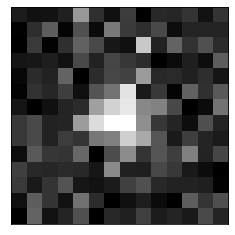

In [13]:
plt.imshow(data[21,2].cpu().numpy(), cmap="gray", vmin=data.vmin, vmax=data.vmax)
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])

plt.show()

In [35]:
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)])

aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_aoi, aoi=aoi_widget, frame=frame_widget, data=fixed(data), binder=False, junk=False)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function cosmos.utils.utils.view_aoi(aoi, frame, data, binder, junk)>

In [30]:
aoi_list = np.unique(framelist["FL_1_1117_0OD"][:,0])

In [24]:
%%timeit
torch.exp(torch.rand(10000))

129 µs ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
%%timeit
torch.log(torch.rand(10000))

130 µs ± 475 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
# aoi detected frame
framelist = loadmat("/home/ordabayev/Documents/Datasets/Bayesian_test_files/B33p44a_FrameList_files.dat")
print(framelist.keys())
#aoi_list = np.unique(framelist["FL_1_1117_0OD"][:,0])
#aoi_list = [1, 2, 3, 4, 5]
OD = "FL_3339_4444_0p8OD"
frames = np.unique(framelist[OD][:,2])
framelist = pd.DataFrame(framelist[OD], columns=["aoi", "detected", "frame"])
framelist

dict_keys(['__header__', '__version__', '__globals__', 'FL_1_1117_0OD', 'FL_1118_2225_0p3OD', 'FL_2226_3338_0p6OD', 'FL_3339_4444_0p8OD', 'FL_4445_5554_1p1OD', 'FL_5555_6684_1p3OD'])


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

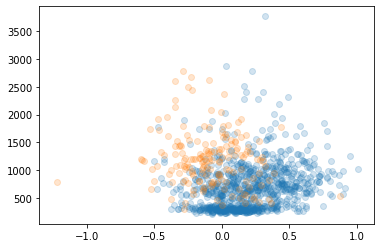

In [60]:
aoi = 0
mask = data.z_probs[aoi,:,1] > 0.
plt.scatter(data.x_mode[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 229
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.x_mode[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
#plt.scatter(data.x_mode[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 210
mask = data.z_probs[aoi,:,1] > 0.5
#plt.scatter(data.x_mode[aoi][mask], data.x_size[aoi][mask], alpha=0.2)
#plt.ylim(0,3000)
#plt.xlim(0,)
plt.show()

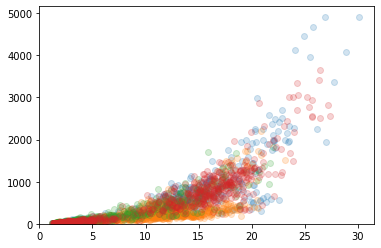

In [16]:
aoi = 229

plt.scatter(data.w_beta[aoi], data.x_size[aoi], alpha=0.2)
#plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 0
plt.scatter(data.w_beta[aoi], data.x_size[aoi], alpha=0.2)

aoi = 179
plt.scatter(data.w_beta[aoi], data.x_size[aoi], alpha=0.2)


aoi = 210
plt.scatter(data.w_beta[aoi], data.x_size[aoi], alpha=0.2)

plt.ylim(0,)
plt.xlim(0,)
plt.show()

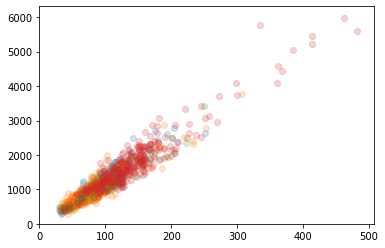

In [18]:
aoi = 229
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)
#plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 0
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)


aoi = 210
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

plt.ylim(0,)
plt.xlim(0,)
plt.show()

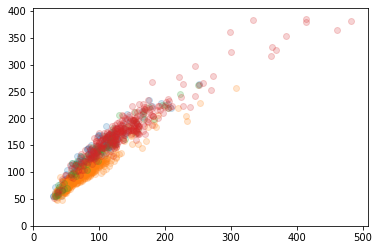

In [24]:
aoi = 229
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_beta[aoi][mask], data.h_loc[aoi][mask], alpha=0.2)
#plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 0
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_beta[aoi][mask], data.h_loc[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_beta[aoi][mask], data.h_loc[aoi][mask], alpha=0.2)


aoi = 210
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_beta[aoi][mask], data.h_loc[aoi][mask], alpha=0.2)

plt.ylim(0,)
plt.xlim(0,)
plt.show()

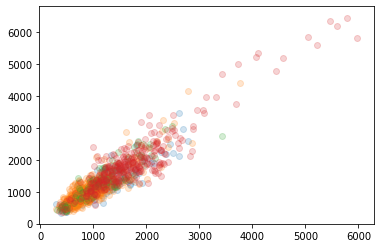

In [29]:
aoi = 229
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.x_size[aoi][mask], data.y_size[aoi][mask], alpha=0.2)
#plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 0
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.x_size[aoi][mask], data.y_size[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.x_size[aoi][mask], data.y_size[aoi][mask], alpha=0.2)


aoi = 210
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.x_size[aoi][mask], data.y_size[aoi][mask], alpha=0.2)

#plt.ylim(0,)
#plt.xlim(0,)
plt.show()

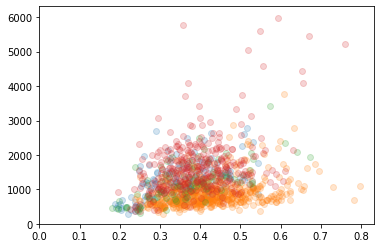

In [20]:
aoi = 229
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)
#plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 0
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)


aoi = 210
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

plt.ylim(0,)
plt.xlim(0,)
plt.show()

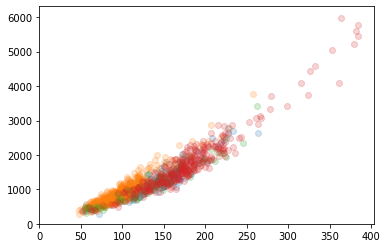

In [21]:
aoi = 229
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_loc[aoi][mask], data.x_size[aoi][mask], alpha=0.2)
#plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 0
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_loc[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_loc[aoi][mask], data.x_size[aoi][mask], alpha=0.2)


aoi = 210
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_loc[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

plt.ylim(0,)
plt.xlim(0,)
plt.show()

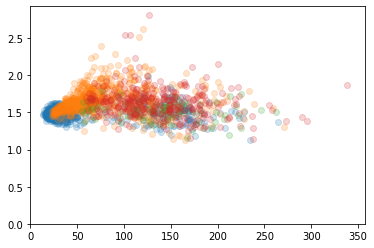

In [90]:
aoi = 229
mask = data.z_probs[aoi,:,1] > 0.
plt.scatter(data.h_loc[aoi][mask], data.w_loc[aoi][mask], alpha=0.2)
#plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)


aoi = 0
mask = data.j_probs[aoi,:,1] > 0.
plt.scatter(data.jh_loc[aoi][mask], data.jw_loc[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_loc[aoi][mask], data.w_loc[aoi][mask], alpha=0.2)

aoi = 179
mask = data.j_probs[aoi,:,1] > 0.5
plt.scatter(data.jh_loc[aoi][mask], data.jw_loc[aoi][mask], alpha=0.2)

plt.ylim(0,)
plt.xlim(0,)
plt.show()

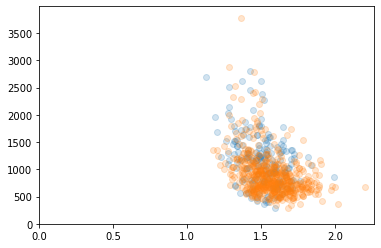

In [80]:
aoi = 229
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_loc[aoi][mask], data.x_size[aoi][mask], alpha=0.2)
#plt.scatter(data.h_beta[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 0
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.w_loc[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
#plt.scatter(data.h_loc[aoi][mask], data.x_size[aoi][mask], alpha=0.2)


aoi = 210
mask = data.z_probs[aoi,:,1] > 0.5
#plt.scatter(data.h_loc[aoi][mask], data.x_size[aoi][mask], alpha=0.2)

plt.ylim(0,)
plt.xlim(0,)
plt.show()

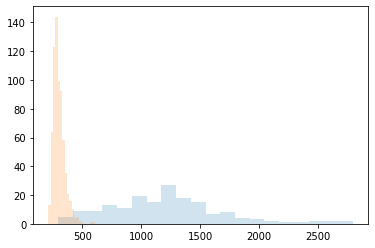

In [66]:
aoi = 229
mask = data.z_probs[aoi,:,1] > 0.5
plt.hist(data.x_size[aoi][mask], bins=20, alpha=0.2)

mask = data.z_probs[aoi,:,1] < 0.5
plt.hist(data.x_size[aoi][mask], bins=20, alpha=0.2)
plt.show()

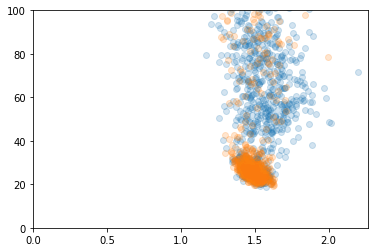

In [52]:
aoi = 0
mask = data.z_probs[aoi,:,1] > 0.
plt.scatter(data.w_loc[aoi][mask], data.w_beta[aoi][mask], alpha=0.2)

aoi = 229
mask = data.z_probs[aoi,:,1] > 0.
plt.scatter(data.w_loc[aoi][mask], data.w_beta[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
#plt.scatter(data.w_loc[aoi][mask], data.w_beta[aoi][mask], alpha=0.2)

aoi = 210
mask = data.z_probs[aoi,:,1] > 0.5
#plt.scatter(data.w_loc[aoi][mask], data.w_beta[aoi][mask], alpha=0.2)
plt.ylim(0,100)
plt.xlim(0,)
plt.show()

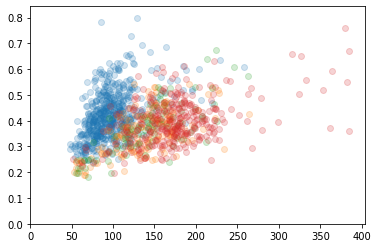

In [94]:
aoi = 0
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_loc[aoi][mask], data.h_beta[aoi][mask], alpha=0.2)

aoi = 229
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_loc[aoi][mask], data.h_beta[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_loc[aoi][mask], data.h_beta[aoi][mask], alpha=0.2)

aoi = 210
mask = data.z_probs[aoi,:,1] > 0.5
plt.scatter(data.h_loc[aoi][mask], data.h_beta[aoi][mask], alpha=0.2)
plt.ylim(0,)
plt.xlim(0,)
plt.show()

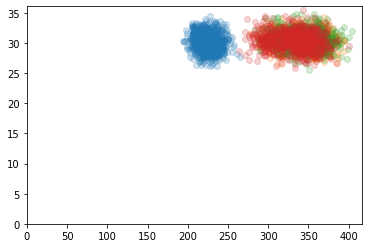

In [19]:
aoi = 0
mask = data.z_probs[aoi,:,1] > 0.
plt.scatter(data.b_loc[aoi][mask], data.b_beta[aoi][mask], alpha=0.2)

aoi = 229
mask = data.z_probs[aoi,:,1] > 0.
plt.scatter(data.b_loc[aoi][mask], data.b_beta[aoi][mask], alpha=0.2)

aoi = 179
mask = data.z_probs[aoi,:,1] > 0.
plt.scatter(data.b_loc[aoi][mask], data.b_beta[aoi][mask], alpha=0.2)

aoi = 210
mask = data.z_probs[aoi,:,1] > 0.
plt.scatter(data.b_loc[aoi][mask], data.b_beta[aoi][mask], alpha=0.2)
plt.ylim(0,)
plt.xlim(0,)
plt.show()

In [ ]:
# h_loc ~ h_beta ~ x_size ~ w_beta
# global_b_beta

In [22]:
torch.nonzero((data.j_probs[:,:,1] > 0.5) & (data.z_probs[:,:,1] > 0.5))[300:315]

tensor([[ 55, 661],
        [ 56,  20],
        [ 56, 237],
        [ 56, 730],
        [ 57, 281],
        [ 57, 282],
        [ 57, 286],
        [ 57, 289],
        [ 57, 295],
        [ 57, 296],
        [ 57, 300],
        [ 57, 302],
        [ 57, 307],
        [ 57, 308],
        [ 57, 309]])

In [ ]:
# dan-pol2 aoi 96 frame 364 430
# aoi 78 frame 500 515
# aoi 180 frame 500

# Modelv1

In [78]:
from scipy.io import loadmat

binary = loadmat("/home/ordabayev/Documents/Datasets/Dan-green-Pol2/b1p139_DNALocations_GreenPolII_BinarySpots.mat")
binary["Intervals"].dtype.names

('AllTracesCellArrayDescription',
 'AllTracesCellArray',
 'CumulativeIntervalArrayDescription',
 'CumulativeIntervalArray',
 'AllSpots')

In [79]:
binary["Intervals"]["CumulativeIntervalArrayDescription"]

array([[array(['(low or high =-2,0,2 or -3,1,3) (frame start) (frame end) (delta frames) (delta time (sec)) (interval ave intensity) AOI#'],
      dtype='<U121')]], dtype=object)

In [80]:
sp = binary["Intervals"]["CumulativeIntervalArray"][0,0][binary["Intervals"]["CumulativeIntervalArray"][0,0][:,-1] == 181, :3]
sp

array([[-2.000e+00,  1.000e+00,  4.800e+01],
       [ 1.000e+00,  4.900e+01,  4.900e+01],
       [ 0.000e+00,  5.000e+01,  1.170e+02],
       [ 1.000e+00,  1.180e+02,  1.320e+02],
       [ 0.000e+00,  1.330e+02,  3.670e+02],
       [ 1.000e+00,  3.680e+02,  3.680e+02],
       [ 0.000e+00,  3.690e+02,  5.560e+02],
       [ 1.000e+00,  5.570e+02,  5.580e+02],
       [ 0.000e+00,  5.590e+02,  5.980e+02],
       [ 1.000e+00,  5.990e+02,  6.380e+02],
       [ 0.000e+00,  6.390e+02,  7.470e+02],
       [ 1.000e+00,  7.480e+02,  7.500e+02],
       [ 0.000e+00,  7.510e+02,  7.630e+02],
       [ 1.000e+00,  7.640e+02,  7.640e+02],
       [ 0.000e+00,  7.650e+02,  9.800e+02],
       [ 1.000e+00,  9.810e+02,  1.031e+03],
       [ 2.000e+00,  1.032e+03,  1.061e+03]])

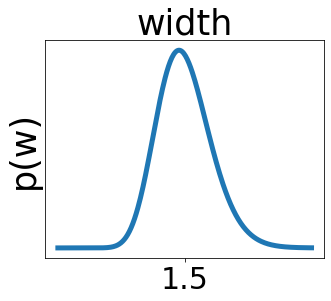

In [8]:
d = dist.Gamma(1.50 * 15, 15)
x = torch.arange(0.01,3.,0.01)

plt.figure(figsize=(5,4))
plt.plot(x, torch.exp(d.log_prob(x)).cpu(), color="C0", lw=5)

plt.gca().axes.get_xaxis().set_ticks([1.5])
plt.gca().axes.get_yaxis().set_ticks([])
plt.xticks(size=30)
plt.title("width", fontsize=35)
plt.ylabel("p(w)", fontsize=35)
plt.show()

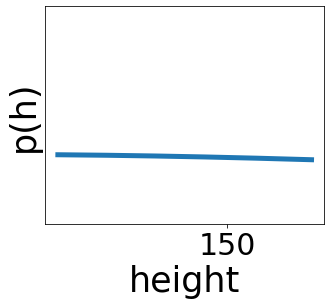

In [19]:
#d = dist.Gamma(150 * 1, 1)
d = dist.HalfNormal(500)
x = torch.arange(50,200.,0.1)

plt.figure(figsize=(5,4))
plt.plot(x, torch.exp(d.log_prob(x)).cpu(), color="C0", lw=5)

plt.gca().axes.get_xaxis().set_ticks([150])
plt.gca().axes.get_yaxis().set_ticks([])
plt.xticks(size=30)
plt.xlabel("height", fontsize=35)
plt.ylabel("p(h)", fontsize=35)
plt.ylim(0,0.005)
plt.show()

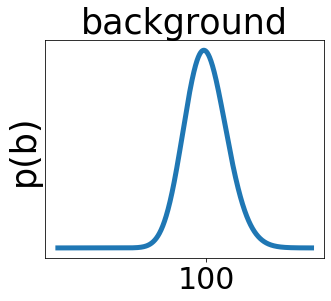

In [12]:
d = dist.Gamma(100 * 1, 1)
x = torch.arange(30,150.,0.1)

plt.figure(figsize=(5,4))
plt.plot(x, torch.exp(d.log_prob(x)).cpu(), color="C0", lw=5)

plt.gca().axes.get_xaxis().set_ticks([100])
plt.gca().axes.get_yaxis().set_ticks([])
plt.xticks(size=30)
plt.title("background", fontsize=35)
plt.ylabel("p(b)", fontsize=35)
plt.show()

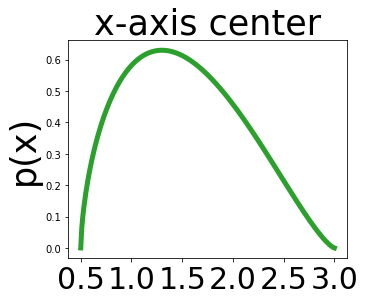

In [51]:
from torch.distributions.transforms import AffineTransform
def Location(mode, size, loc, scale):
    mode = (mode - loc) / scale
    concentration1 = mode * (size - 2) + 1
    concentration0 = (1 - mode) * (size - 2) + 1
    base_distribution = dist.Beta(concentration1, concentration0)
    transforms =  [AffineTransform(loc=loc, scale=scale)]
    return dist.TransformedDistribution(base_distribution, transforms)

D = 14
d = Location(1.3, 4., 0.5, 2.5)
#d2 = Location(0, (((D+3)/(2*0.5))**2 - 1), -(D+3)/2, D+3)
x = torch.arange(-6.,6.,0.01)

plt.figure(figsize=(5,4))
plt.plot(x, torch.exp(d.log_prob(x)).cpu(), color="C2", lw=5)
#plt.plot(x, torch.exp(d2.log_prob(x)).cpu(), color="C3", lw=5)

#plt.gca().axes.get_xaxis().set_ticks([0.])
#plt.gca().axes.get_yaxis().set_ticks([])
plt.xticks(size=30)
plt.title("x-axis center", fontsize=35)
plt.ylabel("p(x)", fontsize=35)
#plt.ylim(0,0.1)
plt.show()

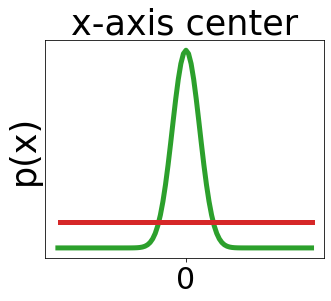

In [18]:
d = dist.Beta(45, 45)
d2 = dist.Beta(1, 1)
x = torch.arange(0,1.,0.01)

plt.figure(figsize=(5,4))
plt.plot(x-0.5, torch.exp(d.log_prob(x)).cpu(), color="C2", lw=5)
plt.plot(x-0.5, torch.exp(d2.log_prob(x)).cpu(), color="C3", lw=5)

plt.gca().axes.get_xaxis().set_ticks([0.])
plt.gca().axes.get_yaxis().set_ticks([])
plt.xticks(size=30)
plt.title("x-axis center", fontsize=35)
plt.ylabel("p(x)", fontsize=35)
plt.show()

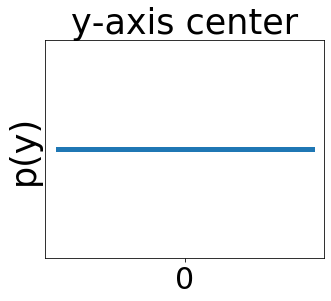

In [24]:
d = dist.Beta(1, 1)
x = torch.arange(0,1.,0.01)

plt.figure(figsize=(5,4))
plt.plot(x-0.5, torch.exp(d.log_prob(x)).cpu(), color="C0", lw=5)

plt.gca().axes.get_xaxis().set_ticks([0.])
plt.gca().axes.get_yaxis().set_ticks([])
plt.xticks(size=30)
plt.title("y-axis center", fontsize=35)
plt.ylabel("p(y)", fontsize=35)
plt.show()

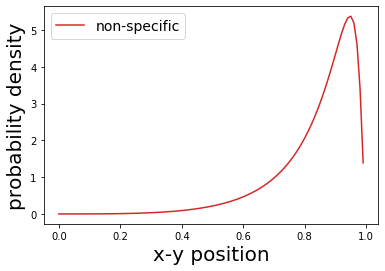

In [50]:
d = dist.Normal(0.5, 0.1)
d2 = lognormal(2., 1.)
d3 = dist.Normal(0., 1.)
d4 = dist.Uniform(-7.5, 7.5)
x = torch.arange(0.,1.,0.01)
y = torch.arange(-5,5,0.1)
#plt.plot(x, torch.exp(d.log_prob(x)).cpu(), color="C1", label="binder")
plt.plot(x, torch.exp(d2.log_prob(x)).cpu(), color="C3", label="non-specific")
#plt.plot(y.cpu(), torch.exp(d3.log_prob(y)).cpu(), label="norm")
#plt.plot(x.cpu(), torch.exp(d4.log_prob(x)).cpu(), label="u7.5")
#plt.ylim(0,0.05)
plt.legend(fontsize=14)
plt.xlabel("x-y position", fontsize=20)
plt.ylabel("probability density", fontsize=20)
plt.show()

## Mathematical model
Product rule
$$ p(X,Z,\theta) = p(X|Z,\theta)p(Z|\theta)p(\theta) = p(Z|\theta,X)p(\theta|X)p(X) $$

Bayes rule
$$ p(Z|\theta,X)p(\theta|X) = \dfrac{p(X|Z,\theta)p(Z|\theta)p(\theta)}{p(X)} $$

$$ p(Z|\pi,X)p(\mu|X)p(\eta|X)p(\pi|X) = \dfrac{p(X|Z,\mu,\eta)p(Z|\pi)p(\mu)p(\eta)p(\pi)}{p(X)} $$

Likelihood
$$ p(X|Z,\mu,\eta) = \prod_f p(X_f|Z_f,\mu,\eta) = \prod_f \prod_{ij} p(X_{fij}|Z_f,\mu,\eta) = \prod_f \prod_{ij} Noise(X_{fij}|Z_f,\mu,\eta) $$

where $\mu$ is a spot model
$$ \mu(height_k,width_k,x_k,y_k,background) $$

Prior
$$ p(Z|\theta) = \prod_f p(Z_f|\theta) = \prod_f Categorical(Z_f|\pi) = \prod_f \prod_k \pi_k^{Z_{fk}} $$

Posterior
$$ p(\theta|X) $$

$$ p(Z|X,\theta) = \prod_f p(Z_f|X_f,\theta) $$

where
$$ \theta = \mu \cup \eta \cup \pi $$

$$ p(x,z,\mu,\sigma, \pi) = p(x|z,\mu,\sigma)p(z|\pi)p(\mu)p(\sigma)p(\pi) $$

$$ \prod_n \prod_f p(x_{nf}|z_{nf},\mu_{nf},\sigma)p(z_{nf}|\pi)p(\mu_{nf})p(\sigma)p(\pi) $$

$$ p(x|z,\mu,\sigma) = \prod_n \prod_f p(x_{nf}|\mu_{nf}[z_f],\sigma) $$

$$ p(z|\pi) = \prod_n \prod_f \pi[z_{nf}] $$

### Spot model
$$ \mu_{fij}(Z_f,height_k,width_k,x_k,y_k,background) $$

$$ p(\mu|X) \simeq q(background) \prod_k q(height_k) q(width_k) q(x_k) q(y_k) $$

$$ q(height_k) = Normal(height\_loc_k, height\_scale_k) $$

$$ q(background) = Normal(background\_loc, background\_scale) $$

$$ q(width_k) = Delta(w_k) $$

$$ q(x_k) = Delta(x_k) $$

$$ q(y_k) = Delta(y_k) $$

### Noise model (Likelihood)

$$ p(X_{fij}|Z_f,\mu,\eta) = Gamma(X_{fij}-offset|\alpha_{fij}, \beta_{fij})Delta(offset) $$
where
$$ \alpha_{fij} = \dfrac{\mu_{fij}(Z_f,\theta)}{gain}; \beta_{fij} = \dfrac{1}{gain} $$

$$ \eta = \{gain, offset\} $$

$$ p(\eta|X) \simeq q(gain) q(offset) = Delta(g)Delta(o) $$

### Classification

$$ p(\pi|X) = q(\pi) =  Dirichlet(\rho_1,...,\rho_K) $$


$$ p(Z_f|X_f,\pi) = q(Z_f) = Categorical(Z_f|z\_prob_f) = \prod_k z\_prob_{fk}^{Z_{fk}} $$